In [1]:
!pip install fastai
!pip install gdown
!pip install annoy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552401 sha256=ec5e4b396cdd695b85011b10763022721fa83b323e55630b298f6bc93dbb09a7
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [2]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.1 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
import pickle
import gdown
import zipfile
import time
%matplotlib inline

from fastai.vision import *
from fastai.vision.all import *
from fastai.metrics import accuracy, top_k_accuracy
from google.colab import drive
from annoy import AnnoyIndex


In [4]:
import ipywidgets as widgets
from IPython.display import display
import requests
from io import BytesIO

In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
link = 'https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb'
outcome = 'img.zip'
gdown.download(link, outcome)

link = 'https://drive.google.com/uc?id=1quO7Fck8MsKum4lzeyMSbbSbL6yGAIDJ'
outcome = 'list_category_img.txt'
gdown.download(link, outcome)

link = 'https://drive.google.com/uc?id=1d1nWNVHdIAvzuGyaSrajuPIffQTjbnsp'
outcome = 'list_category_cloth.txt'
gdown.download(link, outcome)

link = 'https://drive.google.com/uc?id=1_rg5_UZ-ZXkcg0yM_-PlN9yLtYT13sSx'
outcome = 'list_eval_partition.txt'
gdown.download(link, outcome)

root = './'
with zipfile.ZipFile("img.zip","r") as zip_ref:
    zip_ref.extractall(root)

Downloading...
From: https://drive.google.com/uc?id=1j5fCPgh0gnY6v7ChkWlgnnHH6unxuAbb
To: /content/img.zip
100%|██████████| 2.68G/2.68G [00:35<00:00, 76.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1quO7Fck8MsKum4lzeyMSbbSbL6yGAIDJ
To: /content/list_category_img.txt
100%|██████████| 21.4M/21.4M [00:00<00:00, 43.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d1nWNVHdIAvzuGyaSrajuPIffQTjbnsp
To: /content/list_category_cloth.txt
100%|██████████| 882/882 [00:00<00:00, 1.24MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_rg5_UZ-ZXkcg0yM_-PlN9yLtYT13sSx
To: /content/list_eval_partition.txt
100%|██████████| 22.2M/22.2M [00:00<00:00, 99.3MB/s]


In [7]:
categories = []
image_paths = []
data_types = []

# read category names
with open('list_category_cloth.txt', 'r') as f:
    lines = f.readlines()[2:]
    categories = [line.split()[0] for line in lines]

# read image paths and their corresponding categories
with open('list_category_img.txt', 'r') as f:
    lines = f.readlines()[2:]
    image_paths = [[word.strip() for word in line.split() if word] for line in lines]

# read data types (train, validation, or test) for each image
with open('list_eval_partition.txt', 'r') as f:
    lines = f.readlines()[2:]
    data_types = [[word.strip() for word in line.split() if word] for line in lines]

In [8]:
# create a dictionary to hold image paths and their corresponding category numbers
img_dict = {"path": [], "category_id": []}

# iterate through the image paths and add them to the dictionary
for img_path, category in image_paths:
  img_dict["path"].append(img_path)
  img_dict["category_id"].append(int(category) - 1)

# create a DataFrame with image paths and their corresponding category numbers
df = pd.DataFrame(img_dict)

# merge the data types (train, validation, or test) with the DataFrame
df = df.merge(pd.DataFrame(data_types, columns=['path', 'data_type']), on='path')

# add a column with the category name based on the category number
df['category'] = df['category_id'].apply(lambda x: categories[x])

# drop the category number column
df = df.drop('category_id', axis=1)

# show the first few rows of the DataFrame
df.head()

path data_type category
0  img/Sheer_Pleated-Front_Blouse/img_00000001.jpg     train   Blouse
1  img/Sheer_Pleated-Front_Blouse/img_00000002.jpg     train   Blouse
2  img/Sheer_Pleated-Front_Blouse/img_00000003.jpg       val   Blouse
3  img/Sheer_Pleated-Front_Blouse/img_00000004.jpg     train   Blouse
4  img/Sheer_Pleated-Front_Blouse/img_00000005.jpg      test   Blouse

In [9]:
df[['path','data_type']].groupby('data_type').count()

path
data_type        
test        40000
train      209222
val         40000

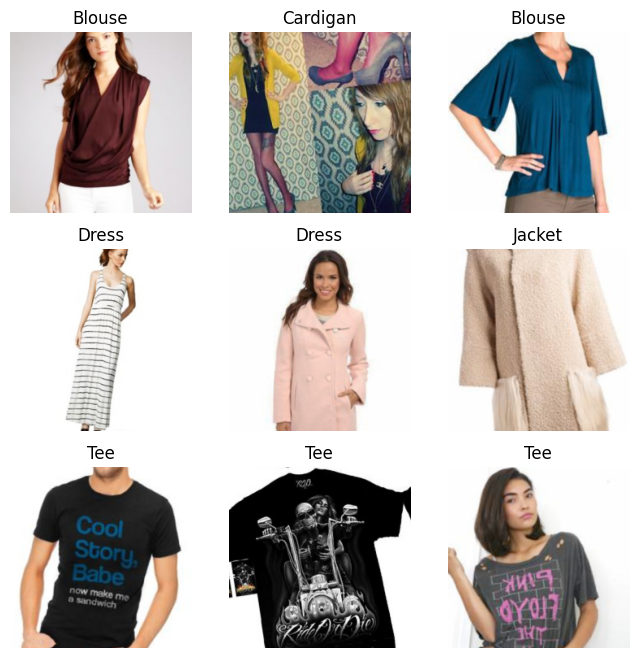

In [12]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=IndexSplitter(df[df['data_type'] == 'test'].index.tolist()),
                   get_x=ColReader('path', pref=root),
                   get_y=ColReader('category'),
                   item_tfms=[Resize(460)],
                   batch_tfms=[*aug_transforms(size=224, max_warp=0)]
                   )

# create dataloaders
dls = dblock.dataloaders(df, bs=128, num_workers=4, pin_memory=True)

# show batch
dls.show_batch(max_n=9, figsize=(8,8))


/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61

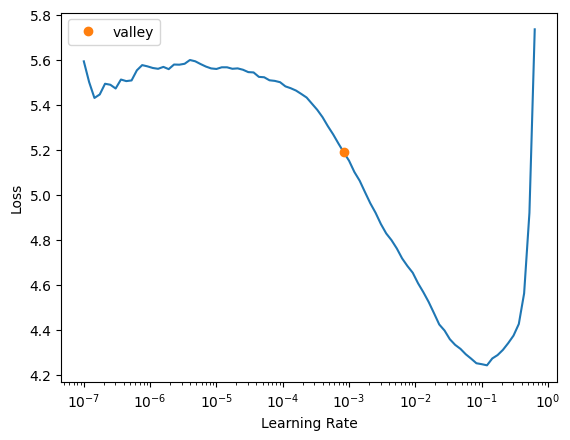

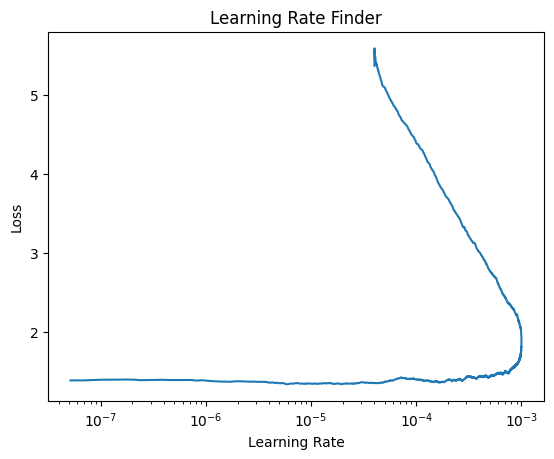

In [ ]:
resnet = models.resnet50 # or models.resnet18
model_accuracy = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]


def resnet_model(dls, resnet, model_accuracy):
    learn = cnn_learner(dls, resnet, metrics=model_accuracy)
    learn.model = torch.nn.DataParallel(learn.model)
    learn.lr_find()
    learn.fit_one_cycle(1)

    learn.recorder.plot_lr_find()
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.title('Learning Rate Finder')

    return learn

learn = resnet_model(dls, resnet, model_accuracy)

In [ ]:
learn.save('/content/gdrive/My Drive/resnet')

Path('/content/gdrive/My Drive/resnet.pth')

In [ ]:
def load_model(dls, resnet, model_accuracy, resnet_path):
  learn = cnn_learner(dls, resnet, metrics=model_accuracy)
  learn.model = torch.nn.DataParallel(learn.model)
  learn = learn.load(resnet_path)
  return learn

In [ ]:
resnet = models.resnet50(pretrained=True) # or models.resnet18
model_accuracy = [accuracy, partial(top_k_accuracy, k=1), partial(top_k_accuracy, k=5)]
resnet_path = '/content/gdrive/My Drive/resnet'

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 201MB/s]


In [ ]:
torch.save(resnet.state_dict(), '/content/gdrive/My Drive/resnet')

In [ ]:
state_dict = torch.load('/content/gdrive/My Drive/resnet')
resnet.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
class_interp = ClassificationInterpretation.from_learner(learn)

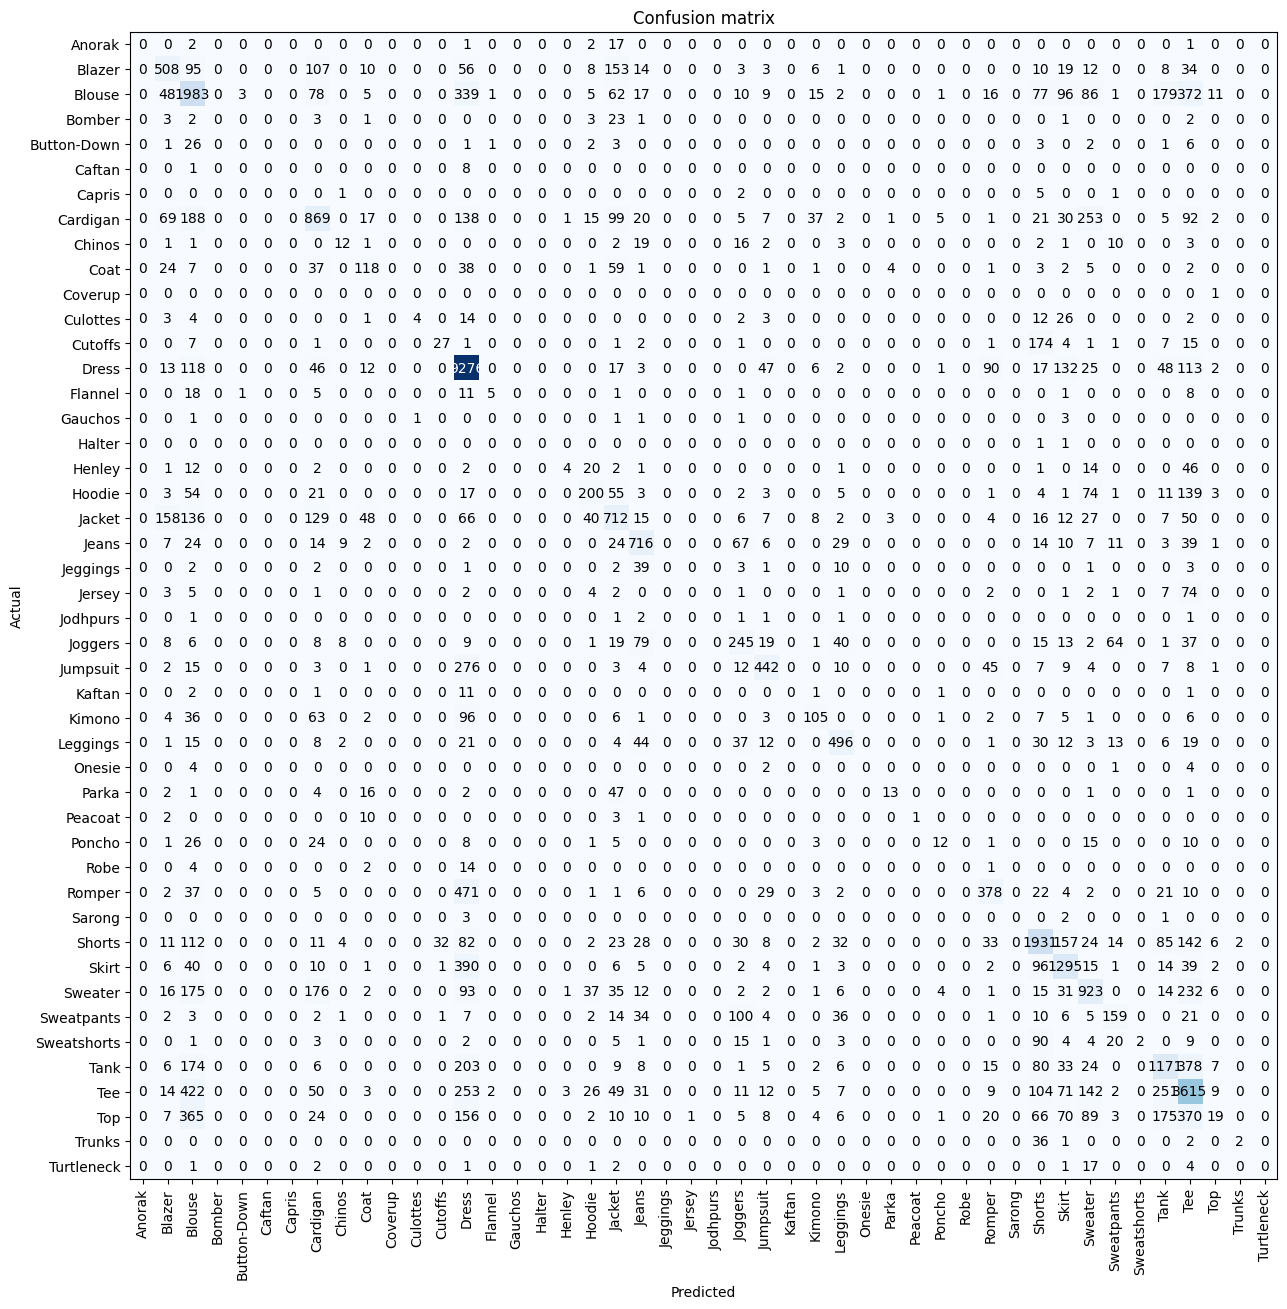

In [ ]:
class_interp.plot_confusion_matrix(figsize=(13,13))

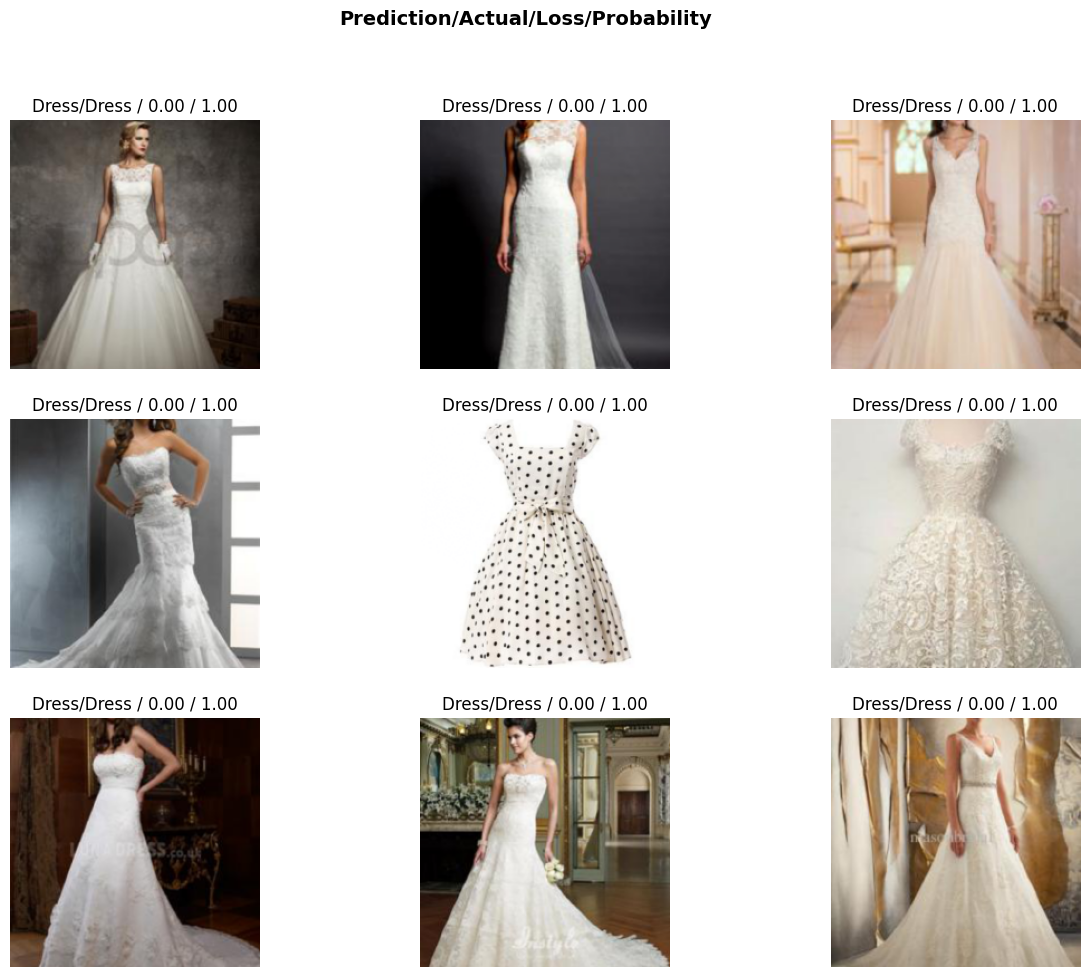

In [ ]:
class_interp.plot_top_losses(9, figsize=(15,11), largest=False)

In [ ]:
#learn.eval()

In [ ]:
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Annoy


In [ ]:
# create a transform to resize and normalize the images
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
def generate_image_embedding(image_path):
    # Load the image and apply the transformation
    image = Image.open(image_path)
    image_tensor = transform(image)
    image_tensor = image_tensor.unsqueeze(0)

    # Generate the image embedding
    with torch.no_grad():
        embedding = resnet(image_tensor).squeeze().numpy()

    return embedding

In [ ]:
# Create a list to hold image embeddings
img_embeddings = []

# Iterate through the image paths and generate the embeddings
for img_path in df['path']:
    img_embedding = generate_image_embedding(img_path)
    img_embeddings.append(img_embedding)

# Create an approximate nearest neighbor index of the embeddings
index = AnnoyIndex(len(img_embeddings[0]), metric='euclidean')
for i, embedding in enumerate(img_embeddings):
    index.add_item(i, embedding)

# Build the index
index.build(n_trees=10)

True

In [ ]:
import os

# Save the image embeddings
embeddings_path = '/content/gdrive/My Drive/image_embeddings.npy'
np.save(embeddings_path, np.array(img_embeddings))

# Check if the file exists
if os.path.exists(embeddings_path):
    print("Image embeddings saved successfully.")
else:
    print("Image embeddings save operation failed.")


Image embeddings saved successfully.


In [ ]:
# Save the Annoy index
index_path = '/content/gdrive/My Drive/annoy_index.ann'
index.save(index_path)

True

In [ ]:
# Load the img_embeddings
img_embeddings = np.load('/content/gdrive/MyDrive/image_embeddings.npy')

# Load the index
index = AnnoyIndex(len(img_embeddings[0]), metric='euclidean')
index.load('/content/gdrive/MyDrive/annoy_index.ann')

True

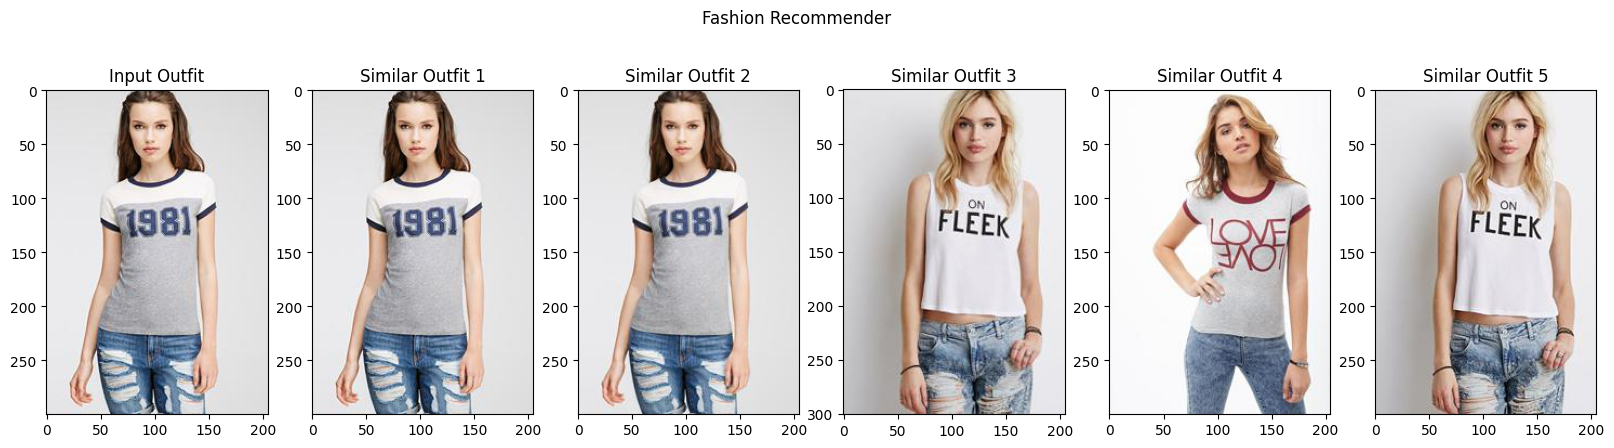

In [ ]:
# Function to recommend similar outfits based on user input
def recommend_similar_outfits(image_path, n_recommendations=5):
    # Generate the embedding for the user input image
    input_embedding = generate_image_embedding(image_path)

    # Get the nearest neighbors of the input image embedding
    neighbor_ids = index.get_nns_by_vector(input_embedding, n_recommendations)

    # Get the corresponding image paths from the DataFrame
    similar_image_paths = df.iloc[neighbor_ids]['path'].tolist()

    # Display the input image and the similar images
    fig, axs = plt.subplots(1, n_recommendations+1, figsize=(20, 5))
    axs[0].imshow(Image.open(image_path))
    axs[0].set_title("Input Outfit")
    for i, path in enumerate(similar_image_paths):
        img = Image.open(path)
        axs[i+1].imshow(img)
        axs[i+1].set_title("Similar Outfit {}".format(i+1))
    plt.suptitle("Fashion Recommender")
    plt.show()

# Example usage:
image_path = '/content/img/1981_Graphic_Ringer_Tee/img_00000001.jpg'
recommend_similar_outfits(image_path, n_recommendations=5)

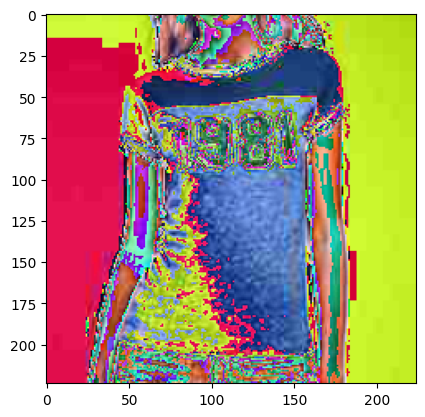

path  \
0  img/Sheer_Pleated-Front_Blouse/img_00000001.jpg   
1  img/Sheer_Pleated-Front_Blouse/img_00000002.jpg   
2  img/Sheer_Pleated-Front_Blouse/img_00000003.jpg   
3  img/Sheer_Pleated-Front_Blouse/img_00000004.jpg   
4  img/Sheer_Pleated-Front_Blouse/img_00000005.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 embedding  \
0  [-0.29320544, -2.0128605, -3.0939798, -3.5096638, -1.719232, -1.5668031, -2.1613467, -3.8110425, -5.5074706, -1.9867346, -1.9750541, -2.5769827, -4.189907, -3.7906814, -2.0875492, -2.4537637, -2.9225378, -2.452791, -2.450803, -1.9328227, -1.5683903, -1.2128239, -0.9260135, -1.6396298, -1.9737067, -1.3412348, -1.1730525, -0.26441747, -0.24139152, -2.4663453, -2.2344882, -4.4468017, -2.3369167, -0.5507286, 1.099309, -1.9350336, -0.45266864, -2.7557244, 0.3782597, -3.40501, -2.7096345, -1.880394, -2.7966113, -0.7289855, -1.0399954, -1.1083256, -3.3062463, -1.2599274, -1.12332, -2.5008304, -0....   
1  [-0.29320544, -2.0128605, -3.0939798, -3.5096638, -1.719232, -1.5668031, -2.1613467, -3.8110425, -5.5074706, -1.9867346, -1.9750541, -2.5769827, -4.189907, -3.7906814, -2.0875492, -2.4537637, -2.9225378, -2.452791, -2.450803, -1.9328227, -1.5683903, -1.2128239, -0.9260135, -1.6396298, -1.9737067, -1.3412348, -1.1730525, -0.26441747, -0.24139152, -2.4663453, -2.2344882, -4.4468017, -2.3369167, -0.5507286, 1.099309, -1.9350336, -0.45266864, -2.7557244, 0.3782597, -3.40501, -2.7096345, -1.880394, -2.7966113, -0.7289855, -1.0399954, -1.1083256, -3.3062463, -1.2599274, -1.12332, -2.5008304, -0....   
2  [-0.29320544, -2.0128605, -3.0939798, -3.5096638, -1.719232, -1.5668031, -2.1613467, -3.8110425, -5.5074706, -1.9867346, -1.9750541, -2.5769827, -4.189907, -3.7906814, -2.0875492, -2.4537637, -2.9225378, -2.452791, -2.450803, -1.9328227, -1.5683903, -1.2128239, -0.9260135, -1.6396298, -1.9737067, -1.3412348, -1.1730525, -0.26441747, -0.24139152, -2.4663453, -2.2344882, -4.4468017, -2.3369167, -0.5507286, 1.099309, -1.9350336, -0.45266864, -2.7557244, 0.3782597, -3.40501, -2.7096345, -1.880394, -2.7966113, -0.7289855, -1.0399954, -1.1083256, -3.3062463, -1.2599274, -1.12332, -2.5008304, -0....   
3  [-0.29320544, -2.0128605, -3.0939798, -3.5096638, -1.719232, -1.5668031, -2.1613467, -3.8110425, -5.5074706, -1.9867346, -1.9750541, -2.5769827, -4.189907, -3.7906814, -2.0875492, -2.4537637, -2.9225378, -2.452791, -2.450803, -1.9328227, -1.5683903, -1.2128239, -0.9260135, -1.6396298, -1.9737067, -1.3412348, -1.1730525, -0.26441747, -0.24139152, -2.4663453, -2.2344882, -4.4468017, -2.3369167, -0.5507286, 1.099309, -1.9350336, -0.45266864, -2.7557244, 0.3782597, -3.40501, -2.7096345, -1.880394, -2.7966113, -0.7289855, -1.0399954, -1.1083256, -3.3062463, -1.2599274, -1.12332, -2.5008304, -0....   
4  [-0.29320544, -2.0128605, -3.0939798, -3.5096638, -1.719232, -1.5668031, -2.1613467, -3.8110425, -5.5074706, -1.9867346, -1.9750541, -2.5769827, -4.189907, -3.7906814, -2.0875492, -2.4537637, -2.9225378, -2.452791, -2.450803, -1.9328227, -1.5683903, -1.2128239, -0.9260135, -1.6396298, -1.9737067, -1.3412348, -1.1730525, -0.26441747, -0.24139152, -2.4663453, -2.2344882, -4.4468017, -2.3369167, -0.5507286, 1.099309, -1.9350336, -0.45266864, -2.7557244, 0.3782597, -3.40501, -2.7096345, -1.880394, -2.7966113, -0.7289855, -1.0399954, -1.1083256, -3.3062463, -1.2599274, -1.12332, -2.5008304, -0....   

  data_type category  
0     train   Blouse  
1     train   Blouse  
2       val   B

In [ ]:
# load an example image and apply the transform
image_path = '/content/img/1981_Graphic_Ringer_Tee/img_00000001.jpg'
image = Image.open(image_path)
image_tensor = transform(image)
image_tensor = image_tensor.unsqueeze(0)
# convert the tensor back to an image and display it
image_display = transforms.ToPILImage()(image_tensor.squeeze())
plt.imshow(image_display)
plt.show()

with torch.no_grad():
  embedding = resnet(image_tensor).squeeze().numpy()

# create a dictionary to hold image paths, category numbers, and embeddings
img_dict = {"path": [], "category_id": [], "embedding": []}

# iterate through the image paths and add them to the dictionary
for img_path, category in image_paths:
    img_dict["path"].append(img_path)
    img_dict["category_id"].append(int(category) - 1)
    img_dict["embedding"].append(embedding)

# create a DataFrame with image paths, category numbers, and embeddings
df = pd.DataFrame(img_dict)

# merge the data types (train, validation, or test) with the DataFrame
df = df.merge(pd.DataFrame(data_types, columns=['path', 'data_type']), on='path')

# add a column with the category name based on the category number
df['category'] = df['category_id'].apply(lambda x: categories[x])

# drop the category number column
df = df.drop('category_id', axis=1)

df.head()


FileUpload(value={}, accept='image/*', description='Upload')

Button(description='Recommend', style=ButtonStyle())

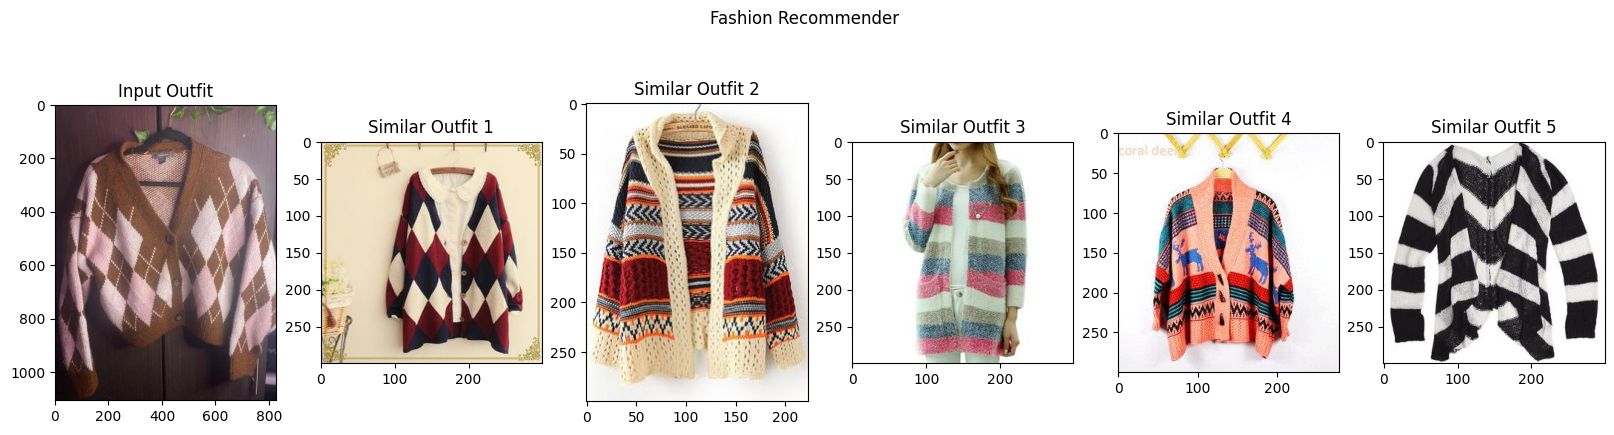

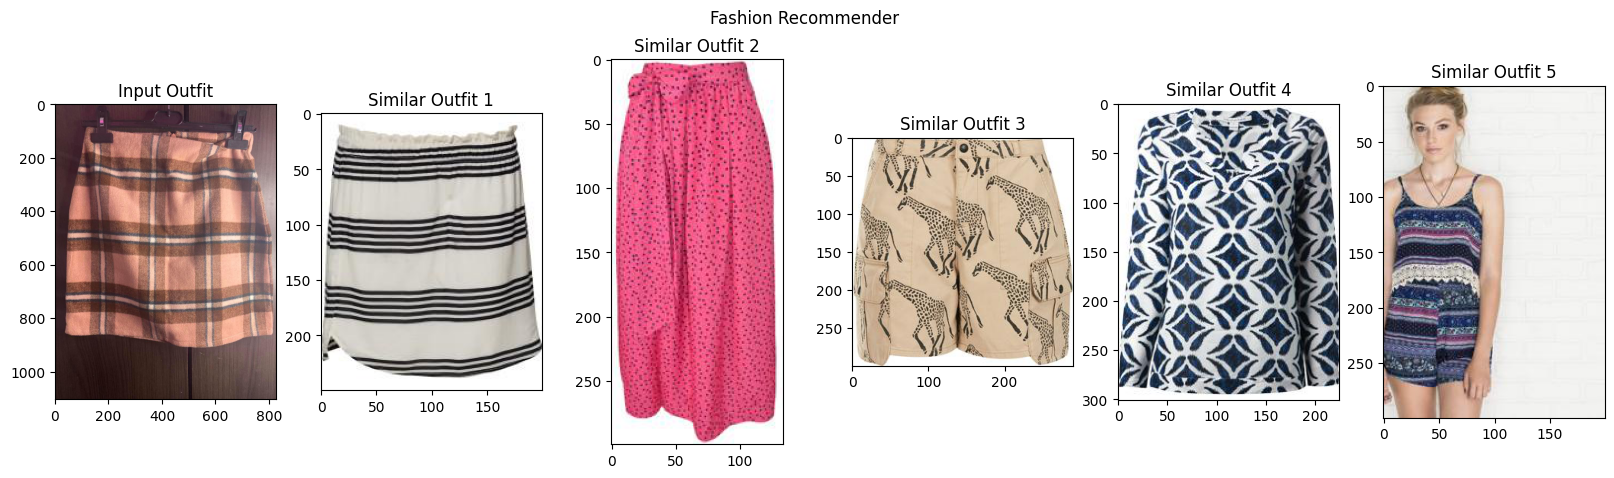

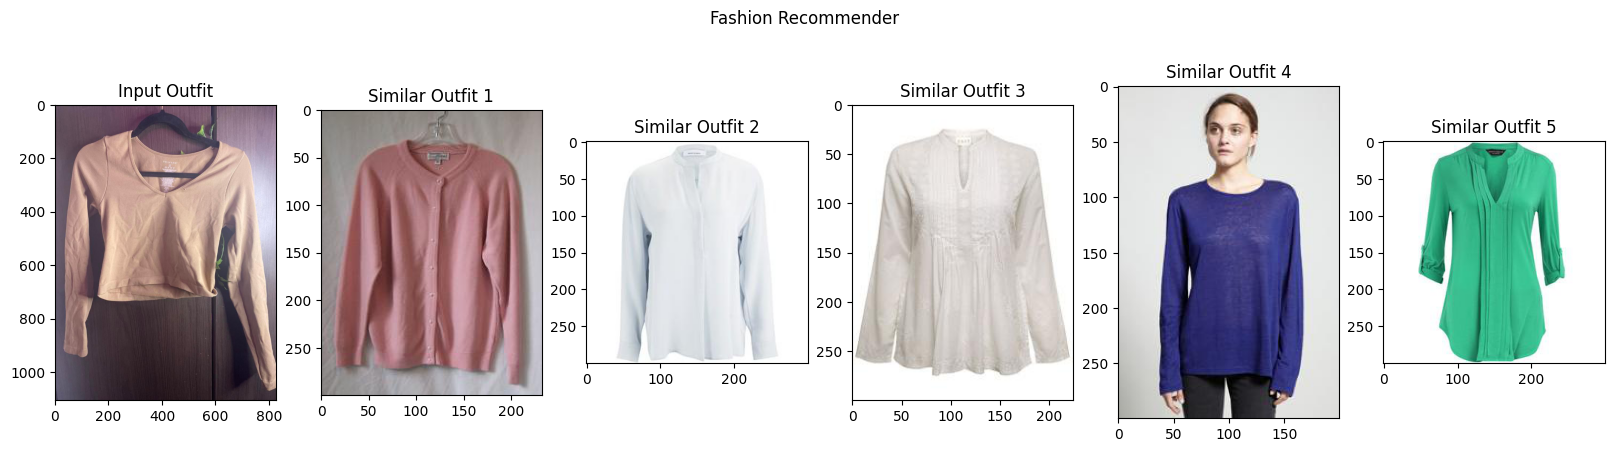

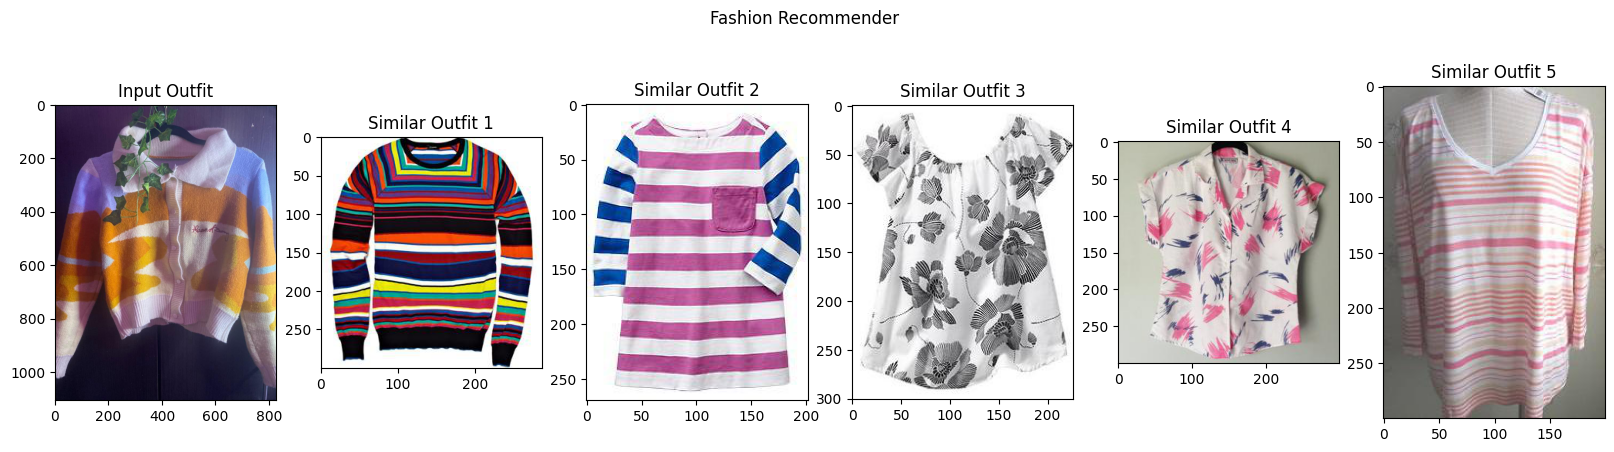

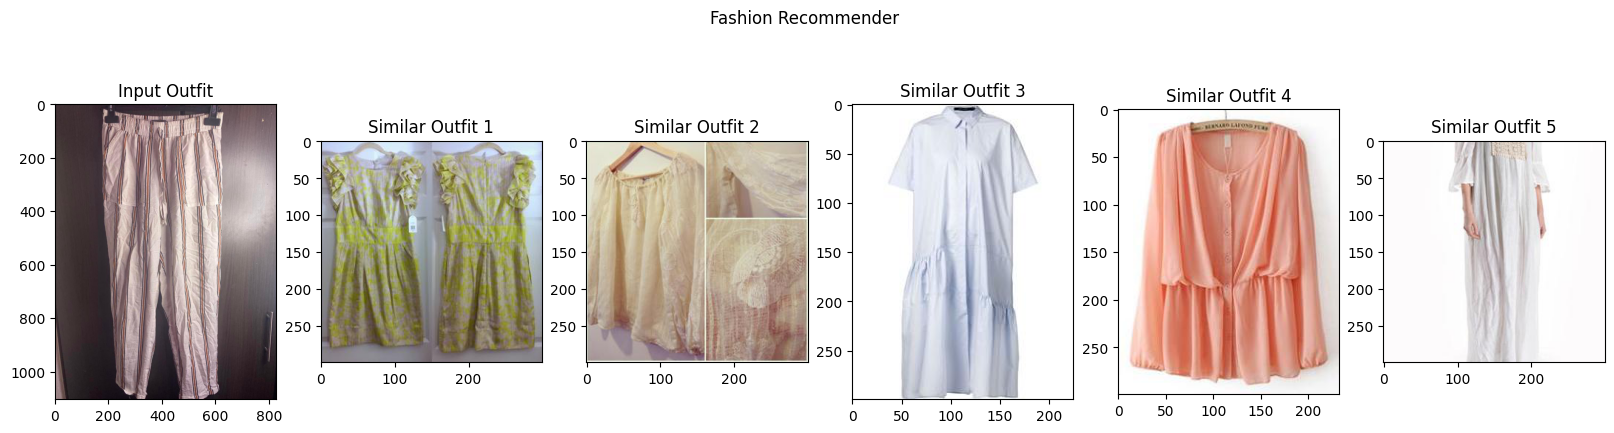

In [ ]:
file_uploader = widgets.FileUpload(accept='image/*')
button = widgets.Button(description='Recommend')

def button_clicked(event):
    if file_uploader.value:
        uploaded_files = file_uploader.value

        if isinstance(uploaded_files, dict) and len(uploaded_files) > 0:
            file_key = next(iter(uploaded_files))
            file_info = uploaded_files[file_key]

            # Get the uploaded image file
            image_file = file_info['content']

            # Create a PIL image from the file
            image = Image.open(BytesIO(image_file))

            # Save the image to a temporary file
            temp_image_path = 'temp_image.jpg'
            image.save(temp_image_path, 'JPEG')

            # Call the recommend_similar_outfits function with the temporary image path
            recommend_similar_outfits(temp_image_path, n_recommendations=5)

            # Clear the file uploader
            file_uploader.value.clear()
        else:
            print('No files uploaded.')
    else:
        print('Please upload an image.')

def hide_output(event):
    button_clicked(event)

button.on_click(hide_output)

display(file_uploader, button)